In [1]:
import os
import platform
import numpy
import sys
import pickle
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import pathlib

from elegant.torch import dataset
from elegant import datamodel
from keypoint_annotation.dataloaders import training_dataloaders

import straightening_analysis_utils
import mask_generation
import measurement_funcs

In [2]:
def has_pose(timepoint):
    pose = timepoint.annotations.get('pose', None)
    # make sure pose is not None, and center/width tcks are both not None
    return pose is not None and pose[0] is not None and pose[1] is not None
    
def has_keypoints(timepoint):
    keypoints = timepoint.annotations.get('keypoints', None)
    return keypoints is not None and not None in keypoints.values() and not False in [x in keypoints.keys() for x in ['anterior bulb', 'posterior bulb', 'vulva', 'tail']]

def save_things(measurement_list, img_type, save_dir):
    summary_stats = straightening_analysis_utils.summary_stats(measurement_list)
    save_dir = os.path.join(save_dir, img_type)
    #save out summary stats
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    log_name = 'summary_stats'+str(img_type)+'.log'
    log_filename = os.path.join(save_dir, log_name)

    fn = open(log_filename, 'a')
    time = datetime.now()
    fn.write('---------------- Straightening Analysis run for {} images on {} ---------------------\n'.format(img_type, time))
    for measurement, sum_stat in summary_stats.items():
        fn.write('{}\n'.format(measurement))
        for stat, val in sum_stat.items():
            fn.write('\t {}\n'.format(stat))
            for k, v in val.items():
                fn.write('\t\t {}:{}\n'.format(k,v))
        fn.write('\n')
    fn.close()

    #save the figures
    for measurement, m_list in measurement_list.items():
        title = 'Distribution of {} in {} straightening analyses'.format(measurement, img_type)
        if measurement == 'emd':
            straightening_analysis_utils.plot_violin(m_list, title, save_dir, measurement, ylabel='EMD Values')
        else:
            straightening_analysis_utils.plot_violin(m_list, title, save_dir, measurement)

def measure_things(os_type):
    print(os_type)
    if os_type == 'Darwin':
        exp_root1 = '/Volumes/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/Volumes/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/Volumes/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
        #exp_root3 = '/mnt/scopearray/Mosley_Matt/glp-1/20190813_lin4gfp_spe9_control'
    elif os_type == 'Linux':
        exp_root1 = '/mnt/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/mnt/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/mnt/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
    
    experiments = [datamodel.Experiment(path) for path in (exp_root1, exp_root2, exp_root3)]

    for experiment in experiments:
        experiment.filter(timepoint_filter=(has_pose, has_keypoints))

    #make at timepoint list and save out the timepoint paths
    timepoint_list = datamodel.Timepoints.from_experiments(*experiments)

    #measure all the things
    measures = [measurement_funcs.measure_emd, measurement_funcs.measure_integrated_gfp, measurement_funcs.measure_area]
    masks = [mask_generation.generate_checkerboard_slice_masks]
    channels = ['bf', 'gfp']
    mnames = ['emd','pixel intensity', 'area']
    
    measure_dict = {}
    for c in channels:
        straightening_analysis_utils.measure_timepoint_list(timepoint_list, mask_generation.generate_checkerboard_slice_masks, measures, mnames, img_type=c)

        measurement_list = straightening_analysis_utils.extract_slice_measurements(timepoint_list, [mnames[0]])
        area = straightening_analysis_utils.extract_slice_area_measurements(timepoint_list, mnames[1:])
        measurement_list.update(area) #update the measurement list to include everything we need
        measure_dict[c] = measurement_list
    return measure_dict
            
def run_straightening_analysis(os_type, save_dir):
    print(os_type)
    if os_type == 'Darwin':
        exp_root1 = '/Volumes/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/Volumes/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/Volumes/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
        #exp_root3 = '/mnt/scopearray/Mosley_Matt/glp-1/20190813_lin4gfp_spe9_control'
    elif os_type == 'Linux':
        exp_root1 = '/mnt/lugia_array/20170919_lin-04_GFP_spe-9/'
        exp_root2 = '/mnt/lugia_array/20190408_lin-4_spe-9_20C_pos-1/'
        #exp_root2 = '/mnt/9karray/Mosley_Matt/20190408_lin-4_spe-9_20C_pos-1/'
        exp_root3 = '/mnt/lugia_array/20190813_lin4gfp_spe9_control/20190813_lin4gfp_spe9_control/'
    
    experiments = [datamodel.Experiment(path) for path in (exp_root1, exp_root2, exp_root3)]

    for experiment in experiments:
        experiment.filter(timepoint_filter=(has_pose, has_keypoints))

    #make at timepoint list and save out the timepoint paths
    timepoint_list = datamodel.Timepoints.from_experiments(*experiments)

    #measure all the things
    measures = [measurement_funcs.measure_emd, measurement_funcs.measure_integrated_gfp, measurement_funcs.measure_area]
    masks = [mask_generation.generate_checkerboard_slice_masks]
    channels = ['bf', 'gfp']
    mnames = ['emd','pixel intensity', 'area']

    for c in channels:
        straightening_analysis_utils.measure_timepoint_list(timepoint_list, mask_generation.generate_checkerboard_slice_masks, measures, mnames, img_type=c)

        measurement_list = straightening_analysis_utils.extract_slice_measurements(timepoint_list, [mnames[0]])
        area = straightening_analysis_utils.extract_slice_area_measurements(timepoint_list, mnames[1:])
        measurement_list.update(area) #update the measurement list to include everything we need

        #save all the things!
        save_things(measurement_list, c, save_dir)

In [ ]:
os_type = platform.system()
measure_dict = measure_things(os_type)

Linux
Completed 0/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Completed 10/6527 timepoints
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Measuring emd
Measuring pixel intensity
Measuring area
Me

In [ ]:
with open('/mnt/lugia_array/Laird_Nicolette/straightening_analysis/measure_dict.pickle', 'wb') as file:
    pickle.dump(measure_dict, file)

In [8]:
measure_dict = pickle.load(open('/mnt/lugia_array/Laird_Nicolette/straightening_analysis/measure_dict.pickle', 'rb'))

In [54]:
def plot_violin(measurement_list, title, save_dir, measurement_name, ylabel='Fraction pixel changed'):
    """Createa violin plot of the data from the measurement list.
    Note: the extract functions give this list
    """
    fig, ax = plt.subplots(figsize=(20,20))
    data = pd.DataFrame.from_dict({k:measurement_list[k] for k in ('warp to unwarped', 'consecutive timepoint measurements', 'worm vs random worm')})
    
    sns.violinplot(data=data, ax=ax, palette='plasma')
    
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
    ax.set_title(title)

    ax.set_ylabel(ylabel)

    save_dir = pathlib.Path(save_dir)
    save_file = save_dir/str(measurement_name+'.png')
    plt.savefig(str(save_file))
    save_file = save_dir/str(measurement_name+'.svg')
    plt.savefig(str(save_file))

    plt.gcf().clf
    plt.close()

In [52]:
def save_things(measurement_list, img_type, save_dir):
    summary_stats = straightening_analysis_utils.summary_stats(measurement_list)
    save_dir = os.path.join(save_dir, img_type)
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    
    #save the figures
    for measurement, m_list in measurement_list.items():
        title = 'Distribution of {} in {} straightening analyses'.format(measurement, img_type)
        if measurement == 'emd':
            plot_violin(m_list, title, save_dir, measurement, ylabel='EMD Values')
        else:
            plot_violin(m_list, title, save_dir, measurement)

In [55]:
importlib.reload(straightening_analysis_utils)
save_dir = '/mnt/lugia_array/Laird_Nicolette/straightening_analysis/'
for c, measurement_list in measure_dict.items():
    c = c+"_seaborn"
    print(c)
    save_things(measurement_list, c, save_dir)

bf_seaborn
gfp_seaborn


consecutive timepoint measurements
warp to unwarped
worm vs random worm
Identifier
consecutive timepoint measurements
warp to unwarped
worm vs random worm
Identifier
consecutive timepoint measurements
warp to unwarped
worm vs random worm
Identifier


{'emd': {'consecutive timepoint measurements': {'mean': 17906.302934464817,
   'std': 9983.112077434116,
   'min': 1624.1881511423478,
   'max': 106525.06264200185,
   'variance': 99662526.7506109},
  'warp to unwarped': {'mean': 1677.8769257752226,
   'std': 562.0674594401659,
   'min': 558.16640122343,
   'max': 4748.097318219664,
   'variance': 315919.82896152243},
  'worm vs random worm': {'mean': 29260.981146147,
   'std': 13333.259212975901,
   'min': 6021.251750875976,
   'max': 111847.10161087646,
   'variance': 177775801.24040675}},
 'pixel intensity': {'consecutive timepoint measurements': {'mean': 0.22593724340900223,
   'std': 0.10243975334114672,
   'min': 0.020270145845730492,
   'max': 1.1354162078042058,
   'variance': 0.010493903064594981},
  'warp to unwarped': {'mean': 0.07997851751639455,
   'std': 0.023843038910328074,
   'min': 0.024744819370734004,
   'max': 0.22159928978195745,
   'variance': 0.0005684905044794185},
  'worm vs random worm': {'mean': 0.3807954340

In [20]:
import pandas as pd
data = pd.DataFrame.from_dict({k:measurement_list[k] for k in ('warp to unwarped', 'consecutive timepoint measurements', 'worm vs random worm')})

In [59]:
means = [data[k].mean() for k in ('warp to unwarped', 'consecutive timepoint measurements', 'worm vs random worm')]
means

[0.07087128008640758, 0.11869258647084219, 0.225632477642731]

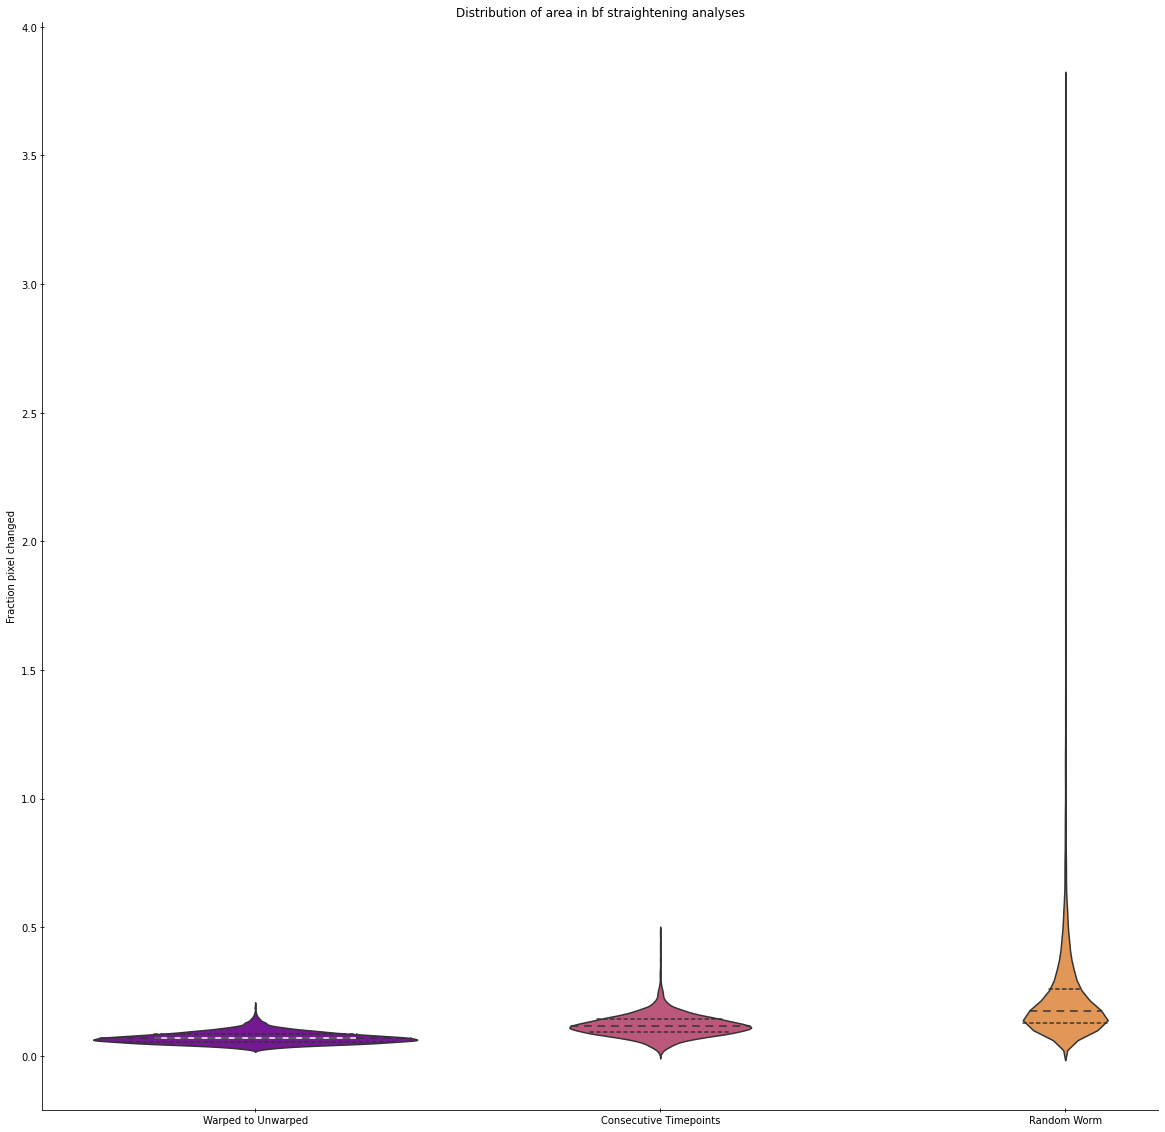

In [75]:
fig, ax = plt.subplots(figsize=(20,20))
sns.violinplot(data=data, ax=ax, palette='plasma', inner='quartile')

ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
ax.set_title("Distribution of area in bf straightening analyses")

ax.set_ylabel('Fraction pixel changed')
ax.hlines(means[0], -0.25,0.25, color='white')

Text(0, 0.5, 'Fraction pixel changed')

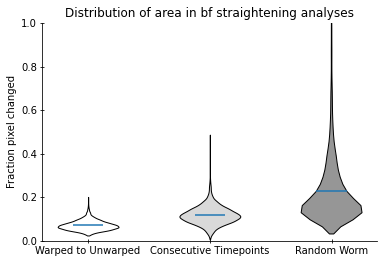

In [121]:
d = measurement_list['area']
cmap = plt.get_cmap('Greys', 5)

#colors = [cmap(i) for i in range(0,3)]
fig, ax = plt.subplots()
positions = numpy.array([1,2,3])

parts = ax.violinplot([d['warp to unwarped'], d['consecutive timepoint measurements'], 
        d['worm vs random worm']], positions, showmeans=True, showextrema=False)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Warped to Unwarped', 'Consecutive Timepoints', 'Random Worm'])
ax.set_title("Distribution of area in bf straightening analyses")

for i, pc in enumerate(parts['bodies']):
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    pc.set_facecolors(cmap(i))
    

ax.set_ylim(0,1.0)

ax.set_ylabel('Fraction pixel changed')

In [95]:
cmap = plt.get_cmap('Pastel1')
cmap(1)

(0.7019607843137254, 0.803921568627451, 0.8901960784313725, 1.0)